In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Files formats

In [56]:
test_df = pd.read_csv('novozymes-data/test.csv')
train_df = pd.read_csv('novozymes-data/updated_train.csv')

print("=============== Test ================")
print(test_df.head())
print()
print("=============== Train ================")
print(train_df.head())


=============== Sample Submission ================
   seq_id  tm
0   31390   0
1   31391   1
2   31392   2
3   31393   3
4   31394   4

=============== Test ================
   seq_id                                   protein_sequence  pH data_source
0   31390  VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes
1   31391  VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes
2   31392  VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...   8   Novozymes
3   31393  VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes
4   31394  VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes

=============== Train ================
   seq_id                                   protein_sequence   pH  \
0       0  AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1       1  AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2       2  AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   
3       3  AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRA

## Duplicates and missing data

In [57]:
print("========================= Training data =======================")
for col in train_df.columns:
    print(f"NaN values for {col} --> {train_df[col].isna().sum()}")
print()

print("========================= Test data =======================")
for col in test_df.columns:
    print(f"NaN values for {col} --> {test_df[col].isna().sum()}")


========================= Training data =======================
NaN values for seq_id --> 0
NaN values for protein_sequence --> 0
NaN values for pH --> 286
NaN values for data_source --> 980
NaN values for tm --> 0

========================= Test data =======================
NaN values for seq_id --> 0
NaN values for protein_sequence --> 0
NaN values for pH --> 0
NaN values for data_source --> 0


In [58]:
print("========================= Training data =======================")
for col in train_df.columns:
    print(f"Unique values for {col} --> {len(train_df[col].unique())}")
print()

print("========================= Test data =======================")
for col in test_df.columns:
    print(f"Unique values for {col} --> {len(test_df[col].unique())}")

========================= Training data =======================
Unique values for seq_id --> 28981
Unique values for protein_sequence --> 27375
Unique values for pH --> 105
Unique values for data_source --> 325
Unique values for tm --> 725

========================= Test data =======================
Unique values for seq_id --> 2413
Unique values for protein_sequence --> 2413
Unique values for pH --> 1
Unique values for data_source --> 1


## pH and melting temperature

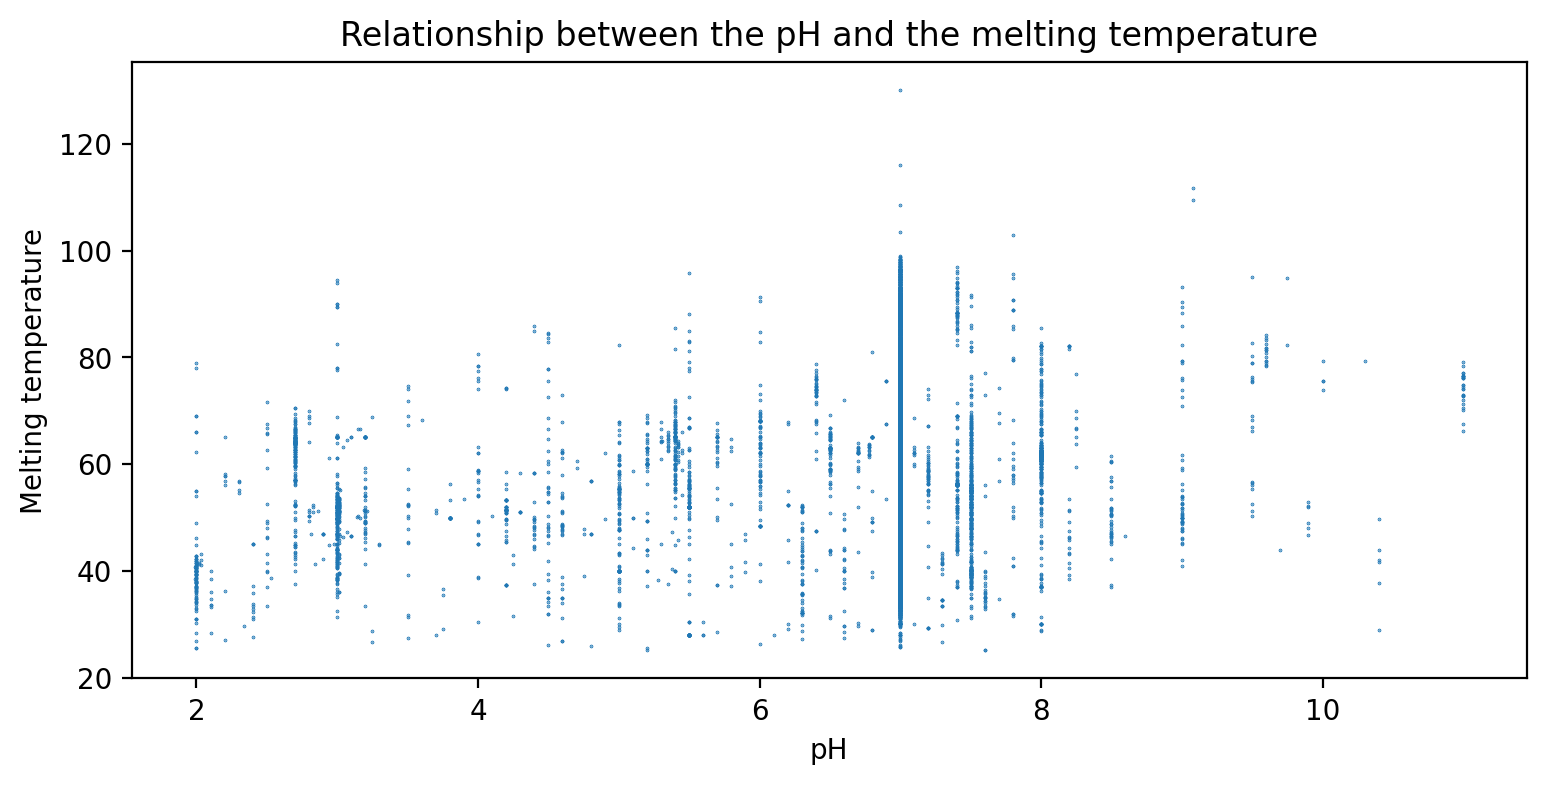

In [59]:
plt.figure(figsize=(9,4), dpi= 200)
plt.scatter(np.clip(train_df["pH"],0,14), train_df["tm"], s=0.1)
plt.title("Relationship between the pH and the melting temperature")
plt.xlabel("pH")
plt.ylabel("Melting temperature")
plt.show()

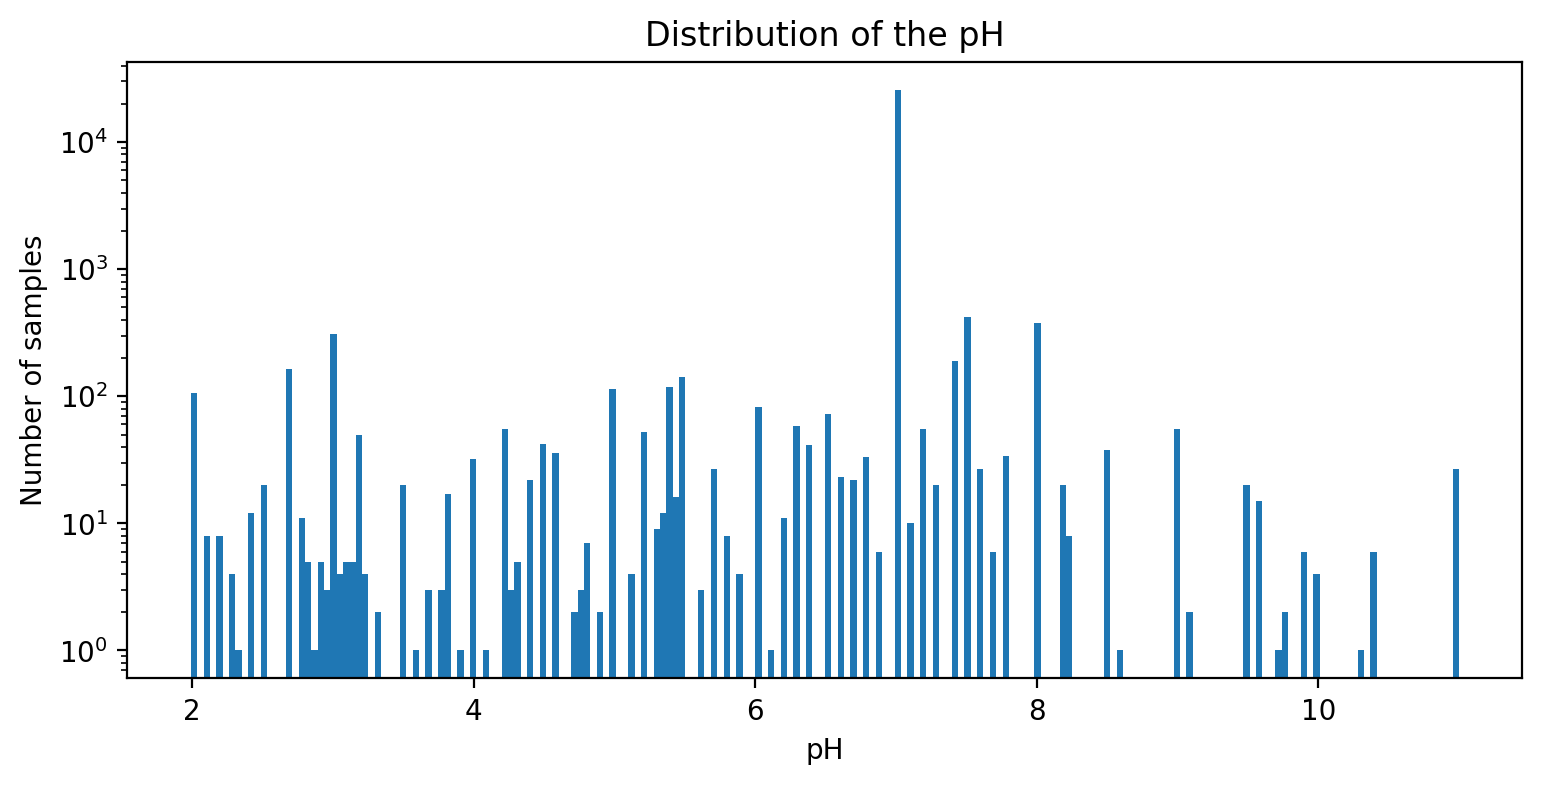

In [60]:
plt.figure(figsize=(9,4), dpi= 200)
plt.hist(np.clip(train_df["pH"],0,14), bins=200)
plt.title("Distribution of the pH")
plt.xlabel("pH")
plt.ylabel("Number of samples")
plt.yscale('log')
plt.show()

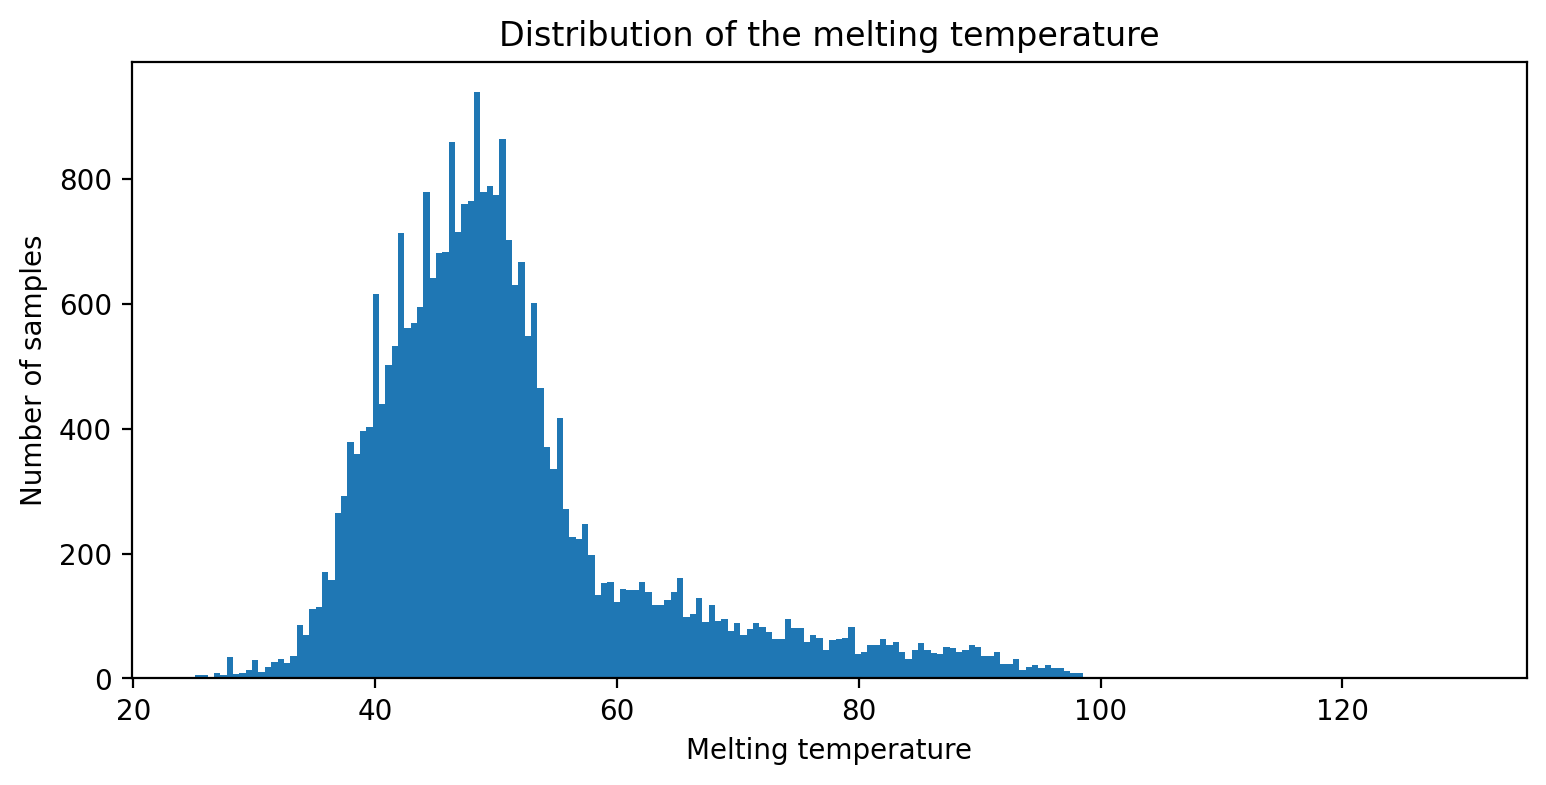

In [61]:
plt.figure(figsize=(9,4), dpi= 200)
plt.hist(train_df["tm"], bins=200)
plt.title("Distribution of the melting temperature")
plt.xlabel("Melting temperature")
plt.ylabel("Number of samples")
plt.show()

## Protein sequences

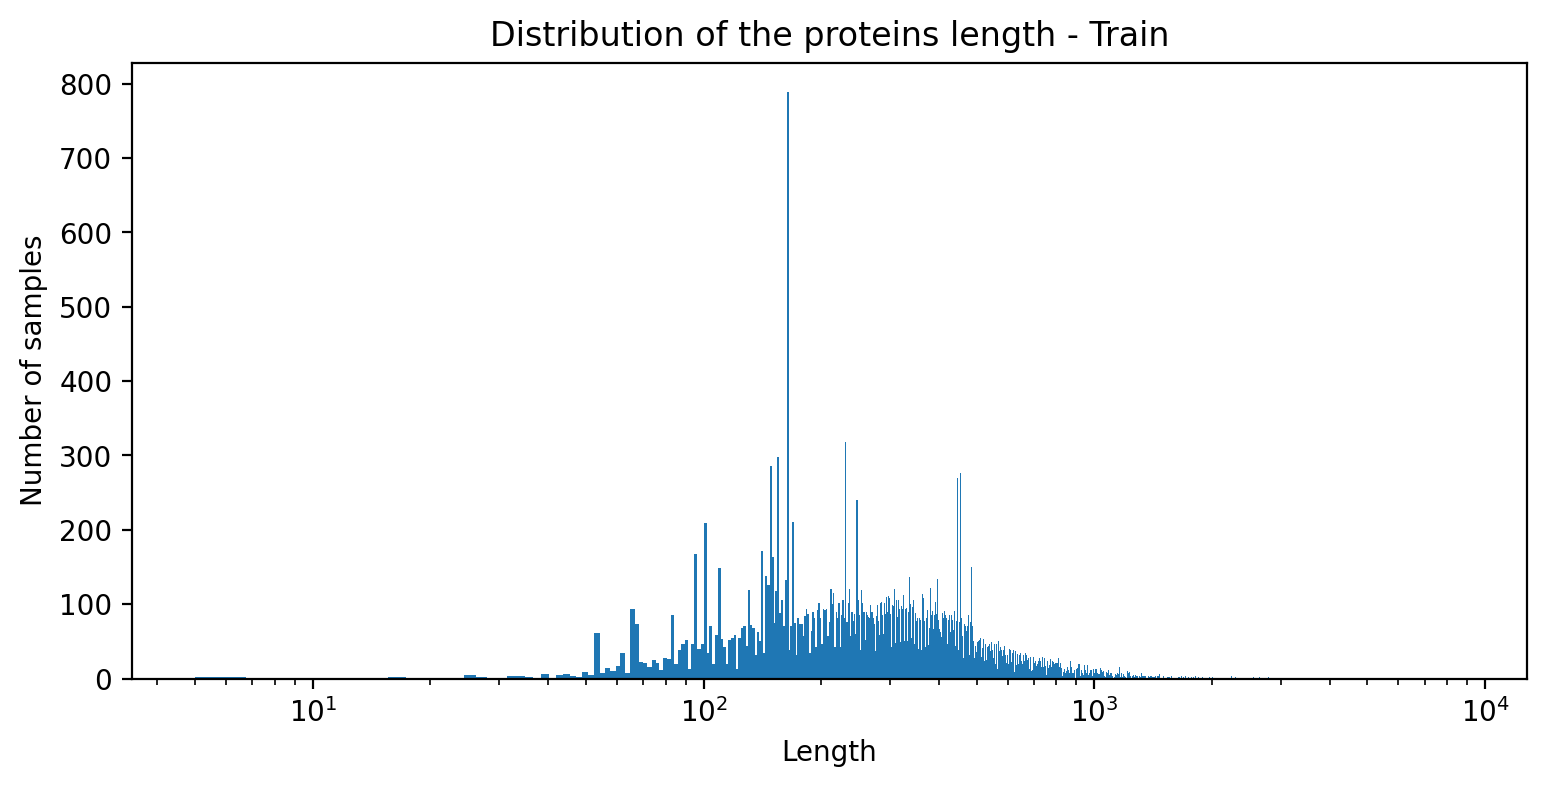

In [62]:
plt.figure(figsize=(9,4), dpi=200)
plt.hist(train_df["protein_sequence"].apply(lambda x:len(x)), 5000)
plt.title("Distribution of the proteins length - Train")
plt.xlabel("Length")
plt.xscale('log')
plt.ylabel("Number of samples")
plt.show()

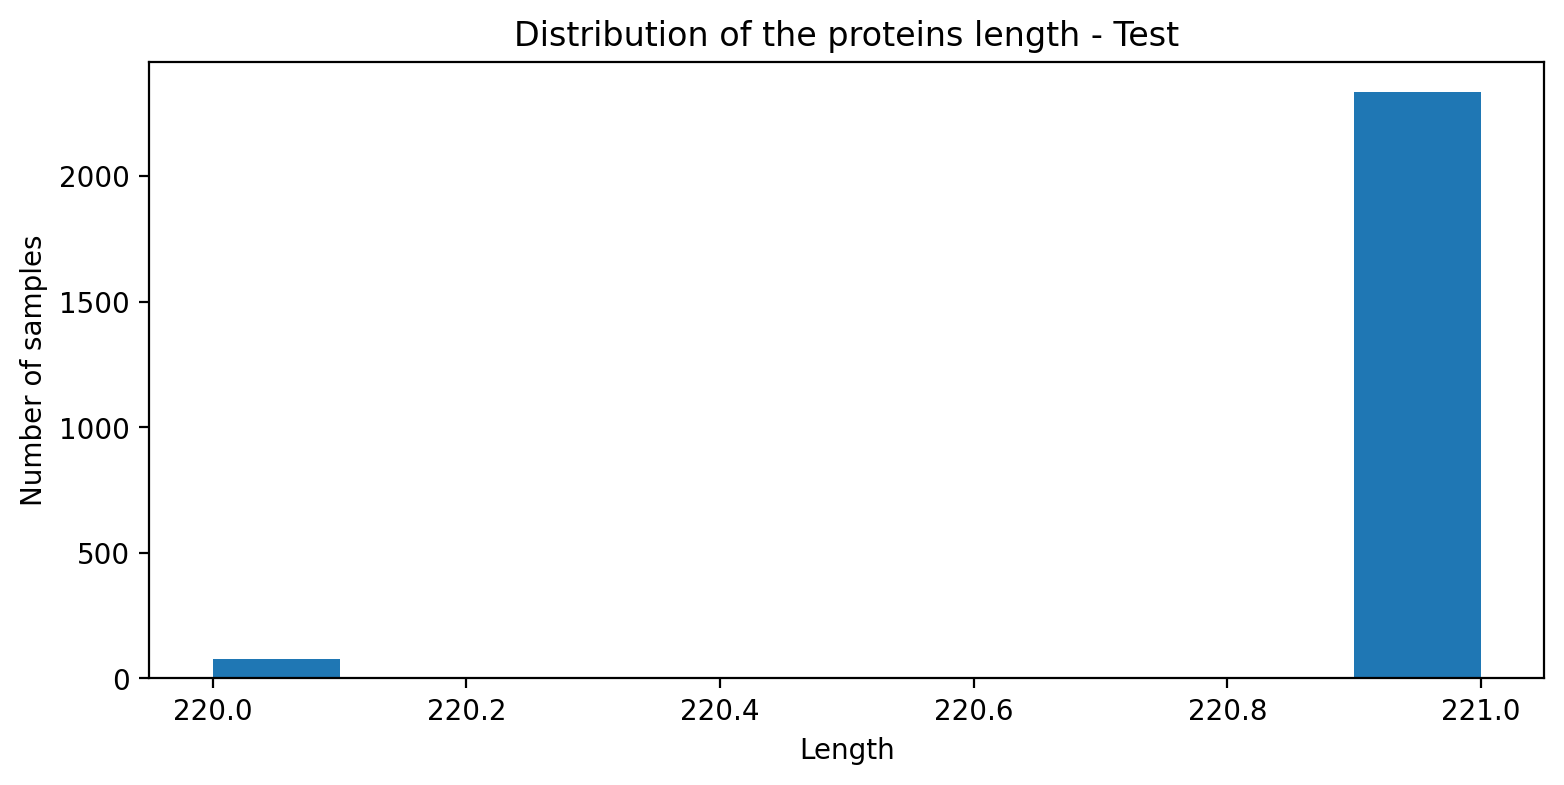

In [63]:
plt.figure(figsize=(9,4), dpi=200)
plt.hist(test_df["protein_sequence"].apply(lambda x:len(x)), 10)
plt.title("Distribution of the proteins length - Test")
plt.xlabel("Length")
plt.ylabel("Number of samples")
plt.show()

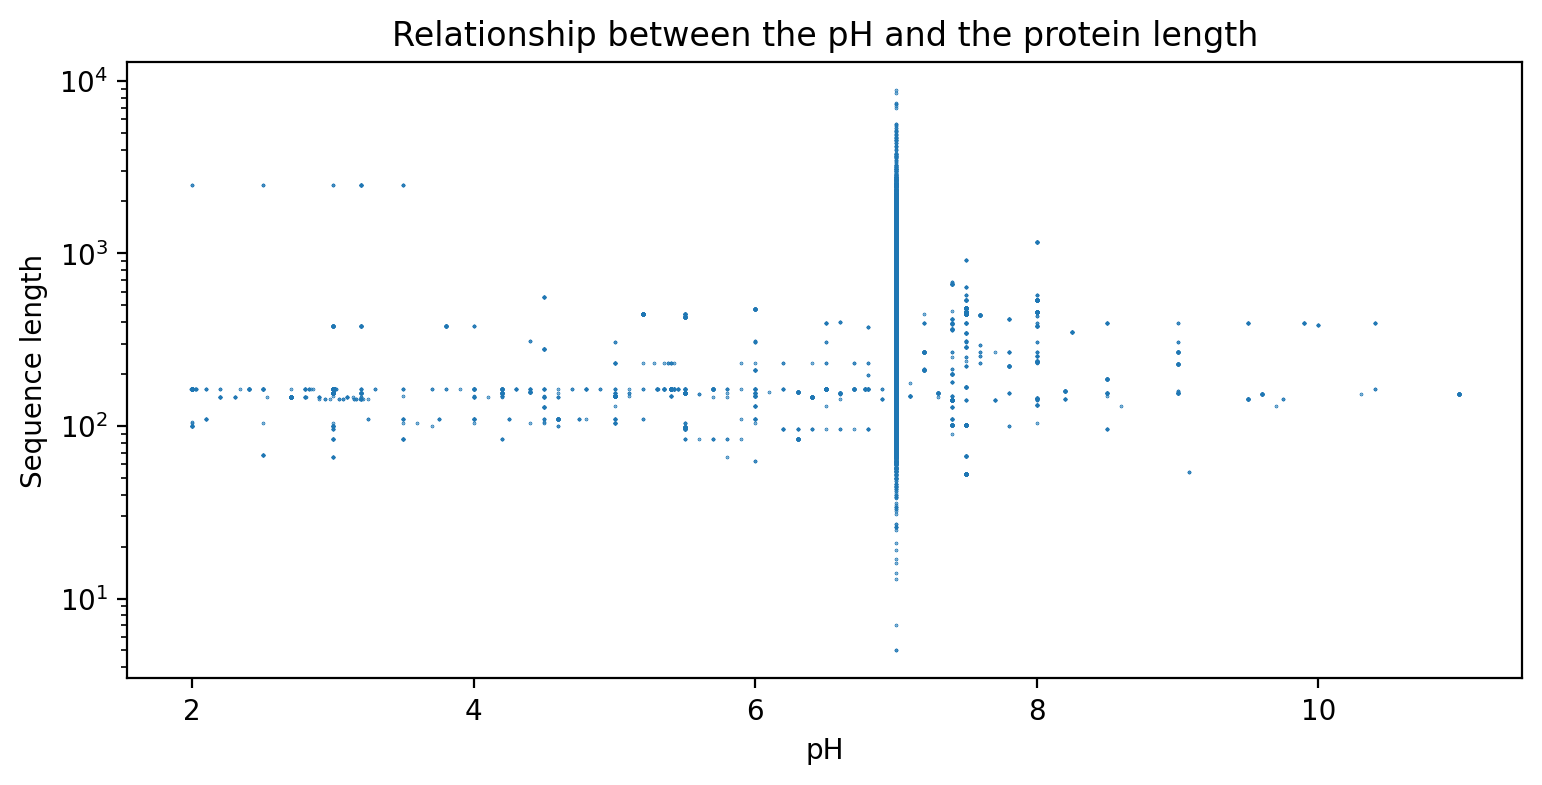

In [64]:
plt.figure(figsize=(9,4), dpi= 200)
plt.scatter(np.clip(train_df["pH"],0,14), train_df["protein_sequence"].apply(lambda x:len(x)), s=0.1)
plt.title("Relationship between the pH and the protein length")
plt.xlabel("pH")
plt.ylabel("Sequence length")
plt.yscale('log')
plt.show()

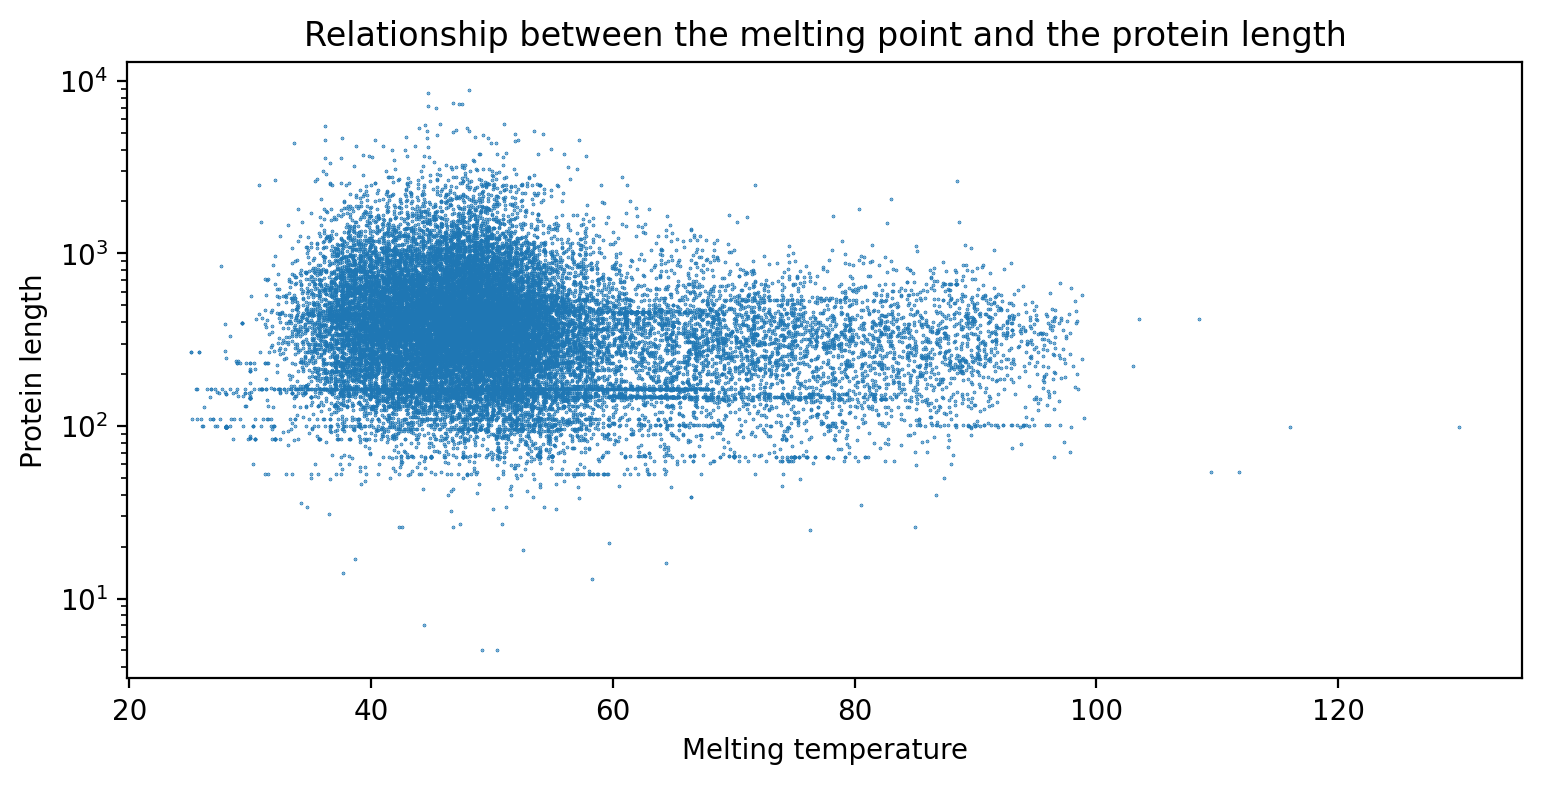

In [65]:
plt.figure(figsize=(9,4), dpi= 200)
plt.scatter(train_df["tm"], train_df["protein_sequence"].apply(lambda x:len(x)), s=0.1)
plt.title("Relationship between the melting point and the protein length")
plt.ylabel("Protein length")
plt.xlabel("Melting temperature")
plt.yscale('log')
plt.show()

## Clustering between proteins

In [66]:
from Levenshtein import distance as lenvenstein_distance
from sklearn.cluster import DBSCAN

In [14]:
dist_matrix = np.zeros((len(train_df),len(train_df)))

for i in tqdm(range(len(train_df))):
    for j in range(max(i-1,0),len(train_df)):

        if abs(len(train_df["protein_sequence"].iloc[i]) - len(train_df["protein_sequence"].iloc[j])) > 15:
            dist_matrix[i,j] = np.inf
        else:
            dist_matrix[i,j] = lenvenstein_distance(train_df["protein_sequence"].iloc[i],
                                                    train_df["protein_sequence"].iloc[j])

        dist_matrix[j,i] = dist_matrix[i,j]
    if i%500 == 0:
        np.save('levenshtein_distance.npy', dist_matrix)

100%|██████████| 31390/31390 [21:03:08<00:00,  2.41s/it]        


In [11]:
dist_matrix = np.load("levenshtein_distance.npy")

In [12]:
def protein_distance(i, j):
    d = dist_matrix[int(i[0]),int(j[0])]
    if np.isnan(d):
        return 20
    return d

In [13]:
global dist_matrix
dbscan_model = DBSCAN(eps= 12, min_samples=2 , metric=protein_distance).fit_predict(train_df.index.to_numpy().reshape(-1,1))

In [48]:
for i in range(-1,max(dbscan_model)+1):
    df = train_df[dbscan_model == i]
    print(f"{i} ---->   {len(df)}")

-1 ---->   23535
0 ---->   2
1 ---->   2
2 ---->   14
3 ---->   2
4 ---->   2
5 ---->   74
6 ---->   2
7 ---->   2
8 ---->   2
9 ---->   2
10 ---->   2
11 ---->   2
12 ---->   2
13 ---->   2
14 ---->   2
15 ---->   11
16 ---->   2
17 ---->   150
18 ---->   2
19 ---->   2
20 ---->   2
21 ---->   2
22 ---->   2
23 ---->   2
24 ---->   2
25 ---->   2
26 ---->   2
27 ---->   8
28 ---->   2
29 ---->   2
30 ---->   2
31 ---->   2
32 ---->   2
33 ---->   2
34 ---->   2
35 ---->   2
36 ---->   2
37 ---->   2
38 ---->   2
39 ---->   2
40 ---->   5
41 ---->   2
42 ---->   2
43 ---->   2
44 ---->   2
45 ---->   58
46 ---->   2
47 ---->   2
48 ---->   26
49 ---->   2
50 ---->   2
51 ---->   2
52 ---->   2
53 ---->   2
54 ---->   2
55 ---->   61
56 ---->   2
57 ---->   2
58 ---->   2
59 ---->   2
60 ---->   2
61 ---->   7
62 ---->   2
63 ---->   2
64 ---->   2
65 ---->   2
66 ---->   2
67 ---->   2
68 ---->   2
69 ---->   3
70 ---->   14
71 ---->   50
72 ---->   2
73 ---->   2
74 ---->   2
75 ---->

In [39]:
len_vec = []
for i in range(0,max(dbscan_model)+1):
    df = train_df[dbscan_model == i]
    len_vec.append(len(df))

In [44]:
ord = list(range(len(len_vec)))
ord.sort(key = lambda x: len_vec[x], reverse=True)

In [46]:
train_df["cluster_label"] = dbscan_model

In [47]:
train_df

,seq_id,protein_sequence,pH,data_source,tm,cluster_label
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,-1
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,-1
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,-1
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,-1
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,-1
...,...,...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8,469
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2,469
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6,469
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7,469


In [19]:
dist_matrix[dist_matrix == np.inf] = np.nan

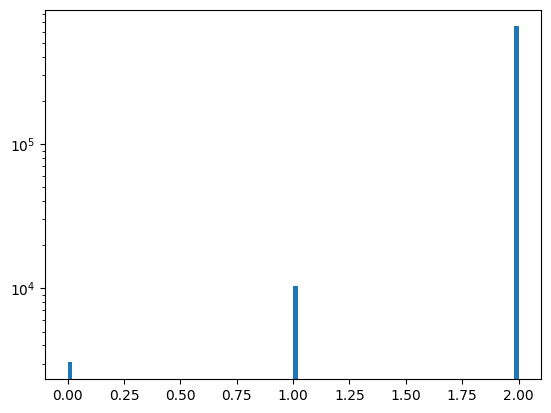

In [38]:
plt.hist(np.clip(dist_matrix[dbscan_model == 295][:,dbscan_model == 295].flatten(),0,600), bins=100)
#plt.xscale('log')
plt.yscale('log')

In [19]:
df = train_df[dbscan_model == 515]
df

,seq_id,protein_sequence,pH,data_source,tm


In [20]:
m = np.zeros((len(df), len(df)))
for i in range(len(m)):
    for j in range(len(m)):
        m[i,j] = lenvenstein_distance(df["protein_sequence"].iloc[i],
                                                    df["protein_sequence"].iloc[j])

/var/folders/cy/1w477czd0_j1kwg81rs879g00000gn/T/ipykernel_32312/761736141.py:1: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  img = plt.imshow(m)
/var/folders/cy/1w477czd0_j1kwg81rs879g00000gn/T/ipykernel_32312/761736141.py:1: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  img = plt.imshow(m)


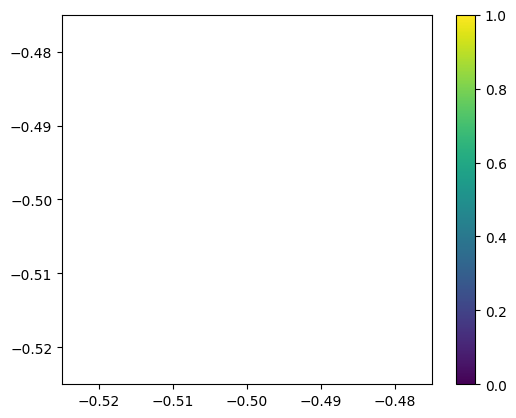

In [21]:
img = plt.imshow(m)
plt.colorbar(img)

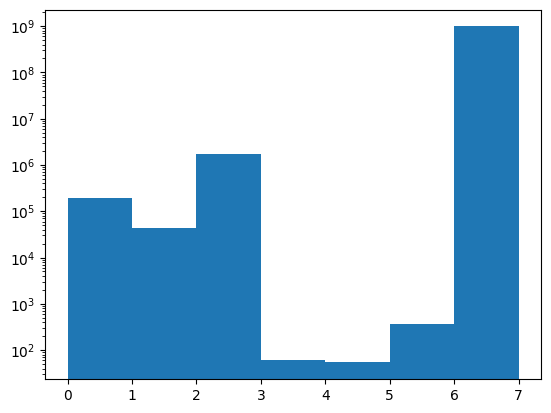

In [22]:
plt.hist(np.clip(dist_matrix.flatten(),0,7), bins=7)
plt.yscale('log')
plt.show()

In [23]:
train_df[train_df["protein_sequence"].duplicated(keep=False)].groupby(['protein_sequence'])[["pH", "tm"]].all()

,pH,tm
protein_sequence,,
DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPTQSYGYYHEYTVITPGARTRGTRRIITGEATQEDYYTGDHYATFSLIDQTC,True,True
DVSGTVCLSALPPEATDTLNLIASDGPFPYSQAGVVFQNRESVLPTQSYGYYHEYTVITPGARTRGTRRIITGEATQEDYYTGDHYATFSLIDQTC,True,True
DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPTQSYGYYHEYTVITPGARTRGTRRIITGEATQEDYYTGDHYATFSLIDQTC,True,True
DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPTQSYGYYHEYTVITPGARTRGTRRIITGEATQEDYYTGDHYATFSLIDQTC,True,True
DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQARESVLPTQSYGYYHEYTVITPGARTRGTRRIITGEATQEDYYTGDHYATFSLIDQTC,True,True
...,...,...
SNMAVVTCGSVVKLLNTRHNVRLHSHDVRYGSGSGQQSVTGVTSVDDSNSYWRIRGKTATVCERGTPIKCGQPIRLTHINTGRNLHSHHFTSPLSGNQEVSAFGEEGEGDYLDDWTVLCNGPYWVRDGEVRFKHSSTDVLLSVTGEQYGRPISGQKEVHGMAQPSQNNYWKAMEGIFMKPSELLRAEVHHAE,True,True
THDLPKAVVKLEPPWIQVLKEDTVTLTCEGTHNPGNSSTQWFHNGRSIRSQVQASYTFKATVNDSGEYRCQMEQTRLSDPVDLGVISDWLLLQTPQLVFLEGETITLRCHSWRNKLLNRISFFHNEKSVRYHHYSSNFSIPKANHSHSGDYYCKGSLGRTLHQSKPVTITVQGPKSSRSLPVLTIVAAVTGIAVAAIVIILVSLVYLKKKQVPALPGNPDHREMGETLPEEVGEYRQPSGGSVPVSPGPPSGLEPTSSSPYNPPDLEEAAKTEAENTITYSLLKHPEALDEETEHDYQNH,True,True
TLSKSDAKKAASKMLLEKTQFSDKPVQDRGLVVTDIKAEDVVLEHRSYCSSRARERNFAGEVLGYVTPWNSHGYDVAKVFGSKFTQISPVWLQLKRRGREMFEITGLHDVDQGWMRAVKKHAKGVRIVPRLLFEDWTYDDFRNVLDSEDEIEELSKTVAQVAKNQHFDGFVVEVWSQLLSQKHVGLIHMLTHLAEALHQARLLVILVIPPAVTPGTDQLGMFTHKEFEQLAPILDGFSLMTYDYSTSQQPGPNAPLSWIRACVQVLDPKSQWRSKILLGLNFYGMDYAASKDAREPVIGARYVQTLKDHRPRVVWDSQAAEHFFEYKKNRGGRHVVFYPTLKSLQVRLELARELGVGVSIWELGQGLDYFYDL,True,True
